In [1]:
import torch
from PIL import Image
from diffusers import AutoencoderKL, UNet2DModel, DDPMScheduler, DDPMPipeline
from diffusers.optimization import get_scheduler
from diffusers.training_utils import EMAModel
import math
import requests
from torchvision.transforms import (
    CenterCrop,
    Compose,
    InterpolationMode,
    Normalize,
    RandomHorizontalFlip,
    Resize,
    ToTensor,
)
from accelerate import Accelerator
import utils
from tqdm import tqdm
import torch.nn.functional as F


/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
training_config = utils.DiffusionTrainingArgs()

In [3]:
# Load an image of my dog for this example

image_url = "https://i.imgur.com/IJcs4Aa.jpeg"
image = Image.open(requests.get(image_url, stream=True).raw)

In [4]:
# Define the transforms to apply to the image for training
augmentations = utils.get_train_transforms(training_config)

In [5]:
train_image = augmentations(image.convert("RGB"))

In [6]:
model = UNet2DModel.from_pretrained("bglick13/minnie-diffusion")


In [23]:
def distill(teacher, n, train_image, epochs=100, lr=3e-4, batch_size=16):
    accelerator = Accelerator(
    gradient_accumulation_steps=training_config.gradient_accumulation_steps,
    mixed_precision=training_config.mixed_precision,
)
    if accelerator.is_main_process:
        run = "distill"
        accelerator.init_trackers(run)
    teacher_scheduler = DDPMScheduler(num_train_timesteps=n)
    student_scheduler = DDPMScheduler(num_train_timesteps=n // 2)
    student = utils.get_unet(training_config)
    student.load_state_dict(teacher.state_dict())
    student = accelerator.prepare(student)
    student.train()
    optimizer = torch.optim.AdamW(
        student.parameters(),
        lr=lr,
        betas=(training_config.adam_beta1, training_config.adam_beta2),
        weight_decay=0.001,
        eps=training_config.adam_epsilon,
    )
    lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=(epochs) // training_config.gradient_accumulation_steps,
)
    teacher, student, optimizer, lr_scheduler, train_image, teacher_scheduler, student_scheduler = accelerator.prepare(
    teacher, student, optimizer, lr_scheduler, train_image,teacher_scheduler, student_scheduler
)
    ema_model = EMAModel(student, inv_gamma=training_config.ema_inv_gamma, power=training_config.ema_power, max_value=training_config.ema_max_decay)
    global_step = 0
    for epoch in range(epochs):
        progress_bar = tqdm(total=1, disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")
        batch = train_image.unsqueeze(0).repeat(
            batch_size, 1, 1, 1
        ).to(accelerator.device)
        with accelerator.accumulate(student):
            noise = torch.randn(batch.shape).to(accelerator.device)
            bsz = batch.shape[0]
            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, student_scheduler.config.num_train_timesteps, (bsz,), device=batch.device
            ).long() * 2
            with torch.no_grad():
                alpha_t, sigma_t = teacher_scheduler.get_alpha_sigma(batch, timesteps + 1, accelerator.device)
                z_t = alpha_t * batch + sigma_t * noise
                alpha_t_prime2, sigma_t_prime2 = student_scheduler.get_alpha_sigma(batch, timesteps // 2, accelerator.device)
                alpha_t_prime, sigma_t_prime = teacher_scheduler.get_alpha_sigma(batch, timesteps, accelerator.device)
                v = teacher(z_t.float(), timesteps + 1).sample
                rec_t = (alpha_t * z_t - sigma_t * v).clip(-1, 1)

                z_t_prime = alpha_t_prime * rec_t + (sigma_t_prime / sigma_t) * (z_t - alpha_t * rec_t)
                v_1 = teacher(z_t_prime.float(), timesteps).sample
                rec_t_prime = (alpha_t_prime * z_t_prime - sigma_t_prime * v_1).clip(-1, 1)
                z_t_prime_2 = alpha_t_prime2 * rec_t_prime + (sigma_t_prime2 / sigma_t_prime) * (z_t_prime - alpha_t_prime * rec_t_prime)
                x_hat = z_t_prime_2 - ((sigma_t_prime2 / sigma_t_prime) * z_t) / (alpha_t_prime2 - (sigma_t_prime2 / sigma_t_prime) * alpha_t)

            noise_pred = student(z_t, timesteps).sample
            student_rec = (alpha_t * z_t - sigma_t * noise_pred).clip(-1, 1)
            loss = F.mse_loss(student_rec, x_hat.clip(-1, 1))
            
            accelerator.backward(loss)

            if accelerator.sync_gradients:
                accelerator.clip_grad_norm_(student.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            if training_config.use_ema:
                ema_model.step(student)
            optimizer.zero_grad()

        # Checks if the accelerator has performed an optimization step behind the scenes
        if accelerator.sync_gradients:
            progress_bar.update(1)
            global_step += 1

        logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
        if training_config.use_ema:
            logs["ema_decay"] = ema_model.decay
        progress_bar.set_postfix(**logs)
        accelerator.log(logs, step=global_step)
        progress_bar.close()

        accelerator.wait_for_everyone()
    return student, ema_model, accelerator
teacher, distilled_ema, distill_accelrator = distill(model, 1000, train_image, epochs=100, batch_size=64)





/tmp/ipykernel_602221/3684360613.py:49: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  alpha_t_prime2, sigma_t_prime2 = student_scheduler.get_alpha_sigma(batch, timesteps // 2, accelerator.device)




Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s, ema_decay=0, loss=0.461, lr=0.000297, step=1]








Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s, ema_decay=0, loss=0.418, lr=0.000294, step=2]








Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s, ema_decay=0.405, loss=0.308, lr=0.000291, step=3]








Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s, ema_decay=0.561, loss=0.368, lr=0.000288, step=4]








Epoch 4: 100%|██████

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_602221/3684360613.py:90 in <module>                                               │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_602221/3684360613.py'                       │
│                                                                                                  │
│ /tmp/ipykernel_602221/3684360613.py:66 in distill                                                │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_602221/3684360613.py'                       │
│                                                                                                  │
│ /home/ben/.local/lib/python3.8/site-packages/accelerate/accelerator.py:1005 in backward          │
│                                                                                                  │
│   1002 │   │   if self.distributed_type == DistributedType.DEEPSPEED:                            │
│   1003 │   │   │   self.deepspeed_engine_wrapped.backward(loss, **kwargs)                        │
│   1004 │   │   elif self.scaler is not None:                                                     │
│ ❱ 1005 │   │   │   self.scaler.scale(loss).backward(**kwargs)                                    │
│   1006 │   │   else:                                                                             │
│   1007 │   │   │   loss.backward(**kwargs)                                                       │
│   1008                                                                                           │
│                                                                                                  │
│ /home/ben/.local/lib/python3.8/site-packages/torch/_tensor.py:396 in backward                    │
│                                                                                                  │
│    393 │   │   │   │   retain_graph=retain_graph,                                                │
│    394 │   │   │   │   create_graph=create_graph,                                                │
│    395 │   │   │   │   inputs=inputs)                                                            │
│ ❱  396 │   │   torch.autograd.backward(self, gradient, retain_graph, create_graph, inputs=input  │
│    397 │                                                                                         │
│    398 │   def register_hook(self, hook):                                                        │
│    399 │   │   r"""Registers a backward hook.                                                    │
│                                                                                                  │
│ /home/ben/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:173 in backward          │
│                                                                                                  │
│   170 │   # The reason we repeat same the comment below is that                                  │
│   171 │   # some Python versions print out the first line of a multi-line function               │
│   172 │   # calls in the traceback and some print out the last line                              │
│ ❱ 173 │   Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the bac   │
│   174 │   │   tensors, grad_tensors_, retain_graph, create_graph, inputs,                        │
│   175 │   │   allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to ru   │
│   176                                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyboardInterrupt

In [ ]:
new_scheduler = DDPMScheduler(num_train_timesteps=500)
pipeline = DDPMPipeline(
    unet=distill_accelrator.unwrap_model(distilled_ema.averaged_model if training_config.use_ema else teacher),
    scheduler=new_scheduler,
)

generator = torch.manual_seed(0)
# run pipeline in inference (sample random noise and denoise)
images = pipeline(generator=generator, batch_size=training_config.batch_size, output_type="numpy").images

# denormalize the images and save to tensorboard
images_processed = (images * 255).round().astype("uint8")

  0%|          | 0/500 [00:00<?, ?it/s]

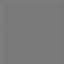

In [ ]:
display(Image.fromarray(images_processed[0]))